# FruitSpec YOLOv4 pipeline

This notebook based on Darknet 'AlexeyAB/darknet' repo. It's main goal- concentrate the entire training cycle under one roof, including testing and logging.

Steps:
1. Installing dependencies.
2. Downloading training data from Roboflow.
3. Writing training configurations.
4. Train.
5. Evaluate.
6. Update current weight file.

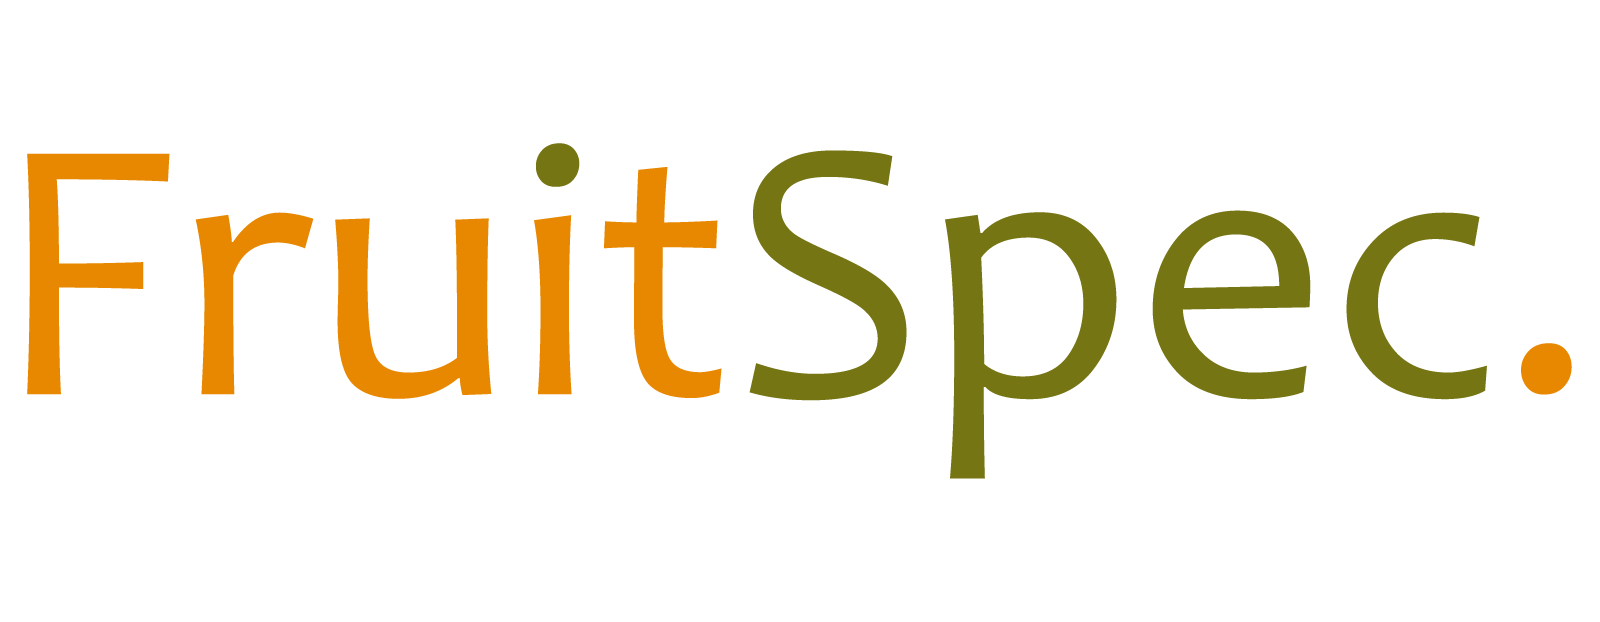




# 1. Intalling dependencies

In [1]:

%%time
import cv2
import os
import wandb
import datetime
from pytz import timezone
from IPython.display import Image, clear_output  # to display images

# from utils.google_utils import gdrive_download  # to download models/datasets
clear_output()
wandb.login()
timestamp = datetime.datetime.now(tz=timezone("Israel")).strftime("%d-%m-%Y_%H:%M:%S")
wandb_project = "YOLOv4-ZED"
trial_name = 'fruitspec_yolov4-tiny_zed_%s' % timestamp
home_dir = os.getcwd()
backup_dir = os.path.join(home_dir, "backup", trial_name)
!mkdir $backup_dir

wandb: Currently logged in as: yotam_ra (use `wandb login --relogin` to force relogin)


mkdir: cannot create directory ‘/home/yotam/PycharmProjects/darknet/backup/fruitspec_yolov4-tiny_zed_24-04-2022_11:20:06’: File exists
CPU times: user 526 ms, sys: 76.3 ms, total: 602 ms
Wall time: 1.72 s


# 2. Downloading training data

We'll download our dataset from Roboflow. Use the "**YOLO DARKNET**" export format. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [30]:

dataset_dir = os.path.join(home_dir, "roboflow-data")

# delete previous datasets
!rm -rf $dataset_dir
!mkdir $dataset_dir

# Make new dir for current dataset version
%cd $dataset_dir
!mkdir $trial_name
%cd $trial_name


# Download from roboflow, paste your link here
!curl -L "https://app.roboflow.com/ds/i5lHDHkxXT?key=VrFA2DHxQK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd ../..

sh: 0: getcwd() failed: No such file or directory
/home/yotam/PycharmProjects/darknet/roboflow-data
/home/yotam/PycharmProjects/darknet/roboflow-data/fruitspec_yolov4-tiny_zed_24-04-2022_11:20:06
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   882  100   882    0     0   1046      0 --:--:-- --:--:-- --:--:--  1045
100 5337M  100 5337M    0     0  32.3M      0  0:02:44  0:02:44 --:--:-- 34.8M0:02:46  0:01:22  0:01:24 32.4M30  0:00:15 30.6M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/15iI6hkcu2an_jpg.rf.284a1b0e5bed43d594e5782cf01e0bae.jpg  
 extracting: test/15iI6hkcu2an_jpg.rf.284a1b0e5bed43d594e5782cf01e0bae.txt  
 extracting: test/1zgSK5N6gREM_jpg.rf.89f015984f8ebc14ba6e30752b654149.jpg  
 extracting: test/1zgSK5N6gREM_jpg.rf.89f015984f8ebc14ba6e30752b654149.txt  
 extracting: test/2Jt6CvOQOpgx_jpg.rf.b2421cff7c5448

# 3. Training configuration and architecture

In order to make training possible, we would have to create various configuration files in accordance to Darknet format.
The following files should be created:
1. obj.data
2. obj.names
3. train.txt
4. val.txt
5. test.txt

Also, we should edit a new .cfg for the current training.

### find out the number of classes

In [31]:
# find out number of classes
unique_class_ids = []
train_dir = os.path.join(dataset_dir, trial_name, "train")
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), 'r') as f:
                line = f.readline()
                class_id = line.split(" ")[0]
                if class_id not in unique_class_ids and class_id is not '':
                    unique_class_ids.append(class_id)

n_classes = len(unique_class_ids)
print(f"CLASSES IDS: {unique_class_ids}")
print(f"NUMBER OF DETECTED CLASSES IS: {n_classes}")


CLASSES IDS: ['0']
NUMBER OF DETECTED CLASSES IS: 1


### rebalance classes

#### create dataframe for easy indexing

In [34]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# build dataframe for training set
### The order of the classes names should be exactly in-order with Roboflow annotations
class_names = ["fruit"]

def create_df():
    columns = ["image_path", "txt_path", "obj_count", "class_name", "class_id", "group"]
    agg_list = []
    for root, dirs, files in os.walk(os.path.join(dataset_dir, trial_name)):
        for file in files:
            if file.endswith(".txt"):
                with open(os.path.join(root, file), 'r') as f:
                    try:
                        line = f.readline()
                        class_id = line.split(" ")[0]
                        class_name = class_names[int(class_id)]
                        line_list = f.read().split("\n")
                        obj_count = 0
                        for i in line_list:
                            obj_count += 1
                        txt_path = os.path.join(root, file)
                        image_path = os.path.join(root, file[:-3] + "jpg")
                        group = str(root.split("/")[-1]).lower()
                        agg_list.append([image_path, txt_path, obj_count, class_name, class_id, group])
                    except:
                        # delete bad files
                        print(f"Error: {file}, deleting...")
                        os.remove(os.path.join(root, file))
                        os.remove(os.path.join(root, file[:-3] + "jpg"))
                        continue

    df = pd.DataFrame(data=agg_list, columns=columns)
    return df

df = create_df()
df_train = df[df["group"] == "train"]
df_train.head()

Error: HD1080_SN30867757_13-20-12_vXwl49noYif5_jpg.rf.a754c9f2b8893b73091b9cdb8a68d00b.txt, deleting...
Error: HD1080_SN31224456_11-58-41_hYX6rhkt2ozm_jpg.rf.75529ef8e32ee2f5396bd89432dc2809.txt, deleting...
Error: HD1080_SN31224456_12-01-17_9c2eFYcOkDRl_jpg.rf.9da8366b3f1b468a9f1002625cbc12e1.txt, deleting...
Error: HD1080_SN31224456_10-09-20_3AWTX0ahKd9E_jpg.rf.f696e434eb31b48bf43ef3083e0b3e34.txt, deleting...
Error: w4qKyGolT2Zl_jpg.rf.4e5f10033fe39654085eef5baafc33ca.txt, deleting...
Error: HD1080_SN31224456_10-19-08_n8wURwW5M9Lv_jpg.rf.946f5f9ecec730f35ad0bb4530b54dfb.txt, deleting...
Error: HD1080_SN31224456_11-53-04_IEKs9y79priS_jpg.rf.8d9fa6b4c8ad9b041e730d87623f4f4a.txt, deleting...
Error: JNj9wDyw8NNB_jpg.rf.669045bbc9b056ae1f3692803a9f61af.txt, deleting...
Error: HD1080_SN30867757_12-08-23_Lc46y9ZkJLMS_jpg.rf.1825e7f4e1aea37582971988ecb57d58.txt, deleting...
Error: HD1080_SN30867757_13-16-29_62egziJDHaIW_jpg.rf.30758fc7ddc4e44ba80559ed515252f4.txt, deleting...
Error: HD1080_

,image_path,txt_path,obj_count,class_name,class_id,group
0,/home/yotam/PycharmProjects/darknet/roboflow-d...,/home/yotam/PycharmProjects/darknet/roboflow-d...,27,fruit,0,train
1,/home/yotam/PycharmProjects/darknet/roboflow-d...,/home/yotam/PycharmProjects/darknet/roboflow-d...,22,fruit,0,train
2,/home/yotam/PycharmProjects/darknet/roboflow-d...,/home/yotam/PycharmProjects/darknet/roboflow-d...,7,fruit,0,train
3,/home/yotam/PycharmProjects/darknet/roboflow-d...,/home/yotam/PycharmProjects/darknet/roboflow-d...,5,fruit,0,train
4,/home/yotam/PycharmProjects/darknet/roboflow-d...,/home/yotam/PycharmProjects/darknet/roboflow-d...,16,fruit,0,train


#### plot class balance

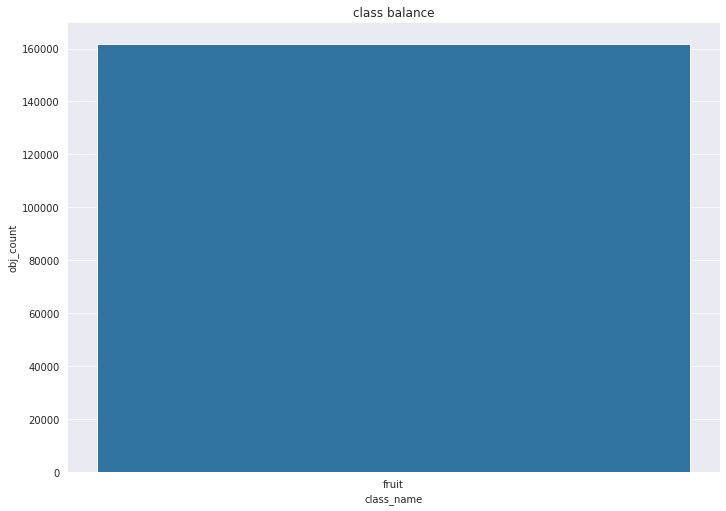

In [35]:
count_df = df_train.groupby("class_name")["obj_count"].sum().reset_index()
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.barplot(data=count_df, x="class_name", y="obj_count");
title = "class balance"
plt.title(title);

#### apply class balancing by adding/removing random images from each class

In [15]:
import shutil
import random
import string

def delete_random(class_name, df_train):
    random_row = df_train[df_train["class_name"] == class_name].sample(1)
    random_image_path = random_row["image_path"].values[0]
    random_txt_path = random_row["txt_path"].values[0]
    delta = random_row["obj_count"].values[0] * -1
    try:
        os.remove(random_image_path)
        os.remove(random_txt_path)
    except:
        pass
    df_train = df_train.drop(random_row.index)
    return df_train, delta


def duplicate_random(class_name):
    random_row = df_train[df_train["class_name"] == class_name].sample(1)
    random_image_path = random_row["image_path"].values[0]
    random_txt_path = random_row["txt_path"].values[0]
    delta = random_row["obj_count"].values[0]
    generated_name = "".join(random.choices(string.ascii_uppercase + string.digits, k=10))
    shutil.copyfile(random_image_path, random_image_path[:-4] + generated_name + ".jpg")
    shutil.copyfile(random_txt_path, random_txt_path[:-4] + generated_name + ".txt")
    return delta

target_count = int(count_df["obj_count"].mean())
for class_name in class_names:
    curr_count = count_df[count_df["class_name"] == class_name]["obj_count"].values
    if curr_count >= target_count:
        while curr_count >= target_count:
            df_train, delta = delete_random(class_name, df_train)
            curr_count += delta
    else:
        while curr_count <= target_count:
            delta = duplicate_random(class_name)
            curr_count += delta

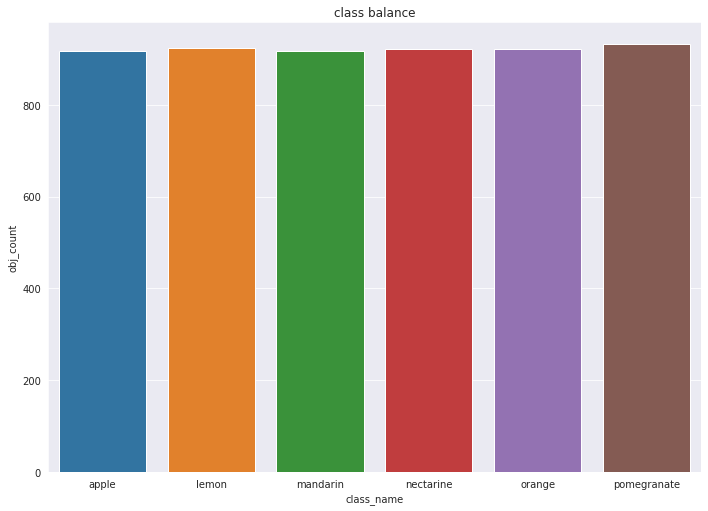

In [16]:
# check balancing
df = create_df()
df_train = df[df["group"] == "valid"]

count_df = df_train.groupby("class_name")["obj_count"].sum().reset_index()
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.barplot(data=count_df, x="class_name", y="obj_count");
title = "class balance"
plt.title(title);

### create train.txt, val.txt and test.txt

In [36]:
train_dir = os.path.join(dataset_dir, trial_name, "train")
val_dir = os.path.join(dataset_dir, trial_name, "valid")
test_dir = os.path.join(dataset_dir, trial_name, "test")

# create train.txt
train_txt_path = os.path.join(dataset_dir, "train.txt")
with open(train_txt_path, "w") as f:
    for root, dirs, files in os.walk(train_dir):
        for file in files:
            if file.endswith(".jpg"):
                f.write(os.path.join(root, file))
                f.write("\n")

# create val.txt
val_txt_path = os.path.join(dataset_dir, "val.txt")
with open(val_txt_path, "w") as f:
    for root, dirs, files in os.walk(val_dir):
        for file in files:
            if file.endswith(".jpg"):
                f.write(os.path.join(root, file))
                f.write("\n")

# create test.txt
test_txt_path = os.path.join(dataset_dir, "test.txt")
with open(test_txt_path, "w") as f:
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if file.endswith(".jpg"):
                f.write(os.path.join(root, file))
                f.write("\n")



### create obj.names file
fetch class names from roboflow

In [37]:

# class_names = ["mandarin", "orange"]
assert len(class_names) == n_classes

obj_names_path = os.path.join(dataset_dir, "obj.names")
with open(obj_names_path, 'w') as f:
    for name in class_names:
        f.write(name)
        f.write("\n")


### create obj.data file
finally, we create thr obj.data file which is the pointer file to all other dataset assets

In [38]:
obj_data_path = os.path.join(dataset_dir, "obj.data")
with open(obj_data_path, 'w') as f:
    f.write(f"classes = {n_classes}\n")
    f.write(f"train = {train_txt_path}\n")
    f.write(f"valid = {val_txt_path}\n")
    f.write(f"test = {test_txt_path}\n")
    f.write(f"names = {obj_names_path}\n")
    f.write(f"backup = {backup_dir}\n")

### parse cfg file and set for current training.

things to consider for each indevidual training:
1. batch size
2. subdivisions
3. max_batches = n_classes * 2000
4. 80% and 90% of max_batches
5. network_size
6. filters in each [convolutional] layer before [yolo] shoud be (n_classes+5)x3

In [46]:
#setup
cfg_file_path = os.path.join(home_dir, "cfg", trial_name + ".cfg")
init_weights = "./yolov4-tiny.conv.29"

In [47]:

#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic


@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [54]:
%%writetemplate $cfg_file_path

[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=8
subdivisions=64
width=1920
height=1920
channels=3
momentum=0.9
decay=0.0005
angle = 0
saturation = 1.5
exposure = 1.5
hue = .1
blur=0.5
gaussian_noise=1

learning_rate=0.00261
burn_in=1000

max_batches = 6000
policy=steps
steps=4800,5600
scales=.1,.1


#weights_reject_freq=1001
#ema_alpha=0.9998
#equidistant_point=1000
#num_sigmas_reject_badlabels=3
#badlabels_rejection_percentage=0.2


[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=1
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6
#new_coords=1
#scale_x_y = 2.0

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=18
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=1
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
resize=1.5
nms_kind=greedynms
beta_nms=0.6
#new_coords=1
#scale_x_y = 2.0


# 4. Train 

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **./darknet detector train** using the compiled trainer
- **obj.data:** path to obj.data file
- **cfg file:** path to .cfg file
- **weights:** path to a weight file to start from, otherwise training will be initialized with random weights.
- **-map:** plot mAP on training graph
- **-dont_show:** won't show graph as a png file.
- **-mjpeg_port PORT:** set port for writing the graph, replace PORT with 8090 for example and the log into https://localhost:8090

In [ ]:
### stepwise parsing log file
# TODO: thread job to parse and upload training data to wandb
!./darknet detector train $obj_data_path $cfg_file_path $init_weights -map -dont_show -mjpeg_port 8090

# 5. Evaluate Model

### Model evaluation process

1. create log files and folders
2. export results to log file
3. parse file and upload to wandb
4. infere test set and upload images to wandb


In [56]:
# init wandb client
test_client = wandb.init(name= trial_name, job_type="Test", project=wandb_project, save_code=True)
# locate weights file
weights_file_path = os.path.join(backup_dir, [n for n in os.listdir(backup_dir) if n.endswith("best.weights")][0])
# init results text file
results_file_path = os.path.join(backup_dir, f"{trial_name}_test_results.txt")
# obj data path
obj_data_path = os.path.join(home_dir, "roboflow-data", "obj.data")
# obj names path
obj_names_path = os.path.join(home_dir, "roboflow-data", "obj.names")
# cfg file path
cfg_file_path = os.path.join(home_dir, "cfg", trial_name + ".cfg")
# test set file path

with open(results_file_path, 'a'): pass

#### run model evaluation and export results to file

In [57]:
# use map function and export to results file
# !./darknet detector map $obj_data_path $cfg_file_path $weights_file_path > results_file_path
!./darknet detector map $obj_data_path $cfg_file_path $weights_file_path -thresh 0.5 -dont_show > $results_file_path

 CUDA-version: 11010 (11040), GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: NVIDIA GeForce RTX 2060 SUPER 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2   1920 x1920 x   3 ->  960 x 960 x  32 1.593 BF
   1 conv     64       3 x 3/ 2    960 x 960 x  32 ->  480 x 480 x  64 8.493 BF
   2 conv     64       3 x 3/ 1    480 x 480 x  64 ->  480 x 480 x  64 16.987 BF
   3 route  2 		                       1/2 ->  480 x 480 x  32 
   4 conv     32       3 x 3/ 1    480 x 480 x  32 ->  480 x 480 x  32 4.247 BF
   5 conv     32       3 x 3/ 1    480 x 480 x  32 ->  480 x 480 x  32 4.247 BF
   6 route  5 4 	                           ->  480 x 480 x  64 
   7 conv     64       1 x 1/ 1    480 x 480 x  64 ->  480 x 480 x  64 1.887 BF
   8 route  2 7 	                           ->  480 x 480 x 128 
   9 max                2x 2/ 2    480 x 480 x 128 ->  240 x 240 x 128 0.029 BF
  10 conv    128       3 x

#### parse results file and upload to wandb dashboard

In [58]:
# format:
# {"fruit name": "fruit id": int, "precision": float, "ap": float}
# FN, FP, TP, overall_precision, overall_recall, mAP.
def per_fruit_descriptive(data_line):
    parsed = data_line.split(",")
    class_id = int(parsed[0].split("=")[-1].replace(" ", ""))
    class_name = str(parsed[1].split("=")[-1].replace(" ", ""))
    ap = float("{:.2f}".format(float(parsed[2].split(" ")[3].replace("%", ""))/100))
    precision = float("{:.2f}".format(float(int(parsed[2].split("(")[-1].split("=")[-1])/(int(parsed[2].split("(")[-1].split("=")[-1]) + int(parsed[3].split("=")[-1].replace(")", ""))))))
    print()
    return class_name, {"fruit_id": class_id, "ap": ap, "percision": precision}
                      
results = {}
with open(results_file_path, 'r') as f:
    for line in f.readlines():
        # fruit data
        if line.startswith("class_id"):
            name, data = per_fruit_descriptive(line)
            results[name] = data
        elif line.startswith(" for conf_thresh = 0.50, precision"):
            parsed = line.split(",")
            results["conf_thres"] = float(parsed[0].split("=")[-1])
            results["overall_percision"] = float(parsed[1].split("=")[-1])
            results["overall_recall"] = float(parsed[2].split("=")[-1])
            results["f1_score"] = float(parsed[3].split("=")[-1])
        elif line.startswith(" for conf_thresh = 0.50, TP"):
            parsed = line.split(",")
            results["TP"] = int(parsed[1].split("=")[-1])
            results["FP"] = int(parsed[2].split("=")[-1])
            results["FN"] = int(parsed[3].split("=")[-1])
        elif line.startswith(" mean average precision (mAP"):
            parsed = line.split(",")
            results["mAP"] = float("{:.2f}".format(float(parsed[0].split("=")[-1].replace(" ", ""))))
            
# upload to wandb
test_client.log(results)

#### Run prediction directly on test svo files and upload results to wandb dashboard

In [10]:
trial_name

'fruitspec_yolov4-tiny_zed_24-04-2022_11:20:06'

#### Upload new model to wandb 

In [13]:
run = wandb.init(name=trial_name, job_type="Artifact Upload", project=wandb_project, save_code=True)
artifact = wandb.Artifact("YOLOv4-model", type='model')
artifact.add_file(weights_file_path)
artifact.add_file(cfg_file_path)
artifact.add_file(obj_data_path)
artifact.add_file(obj_names_path)
run.log_artifact(artifact, aliases=['latest'])